In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
from skimage import color

In [2]:
# Set device to cuda if available
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [3]:
# 1) Loading the dataset
my_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   transforms.Resize(size=(32, 32))
                                   ])
training_data = datasets.CIFAR10(root='./data',
                                 train=True,
                                 download=False, 
                                 transform=my_transform)
validation_data = datasets.CIFAR10(root='./data', 
                                   train=False, 
                                   download=False,
                                   transform=my_transform)
training_loader = torch.utils.data.DataLoader(dataset=training_data,
                                              batch_size=100, 
                                              shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_data,
                                                batch_size=100,
                                                shuffle=False)
validation_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
           )

torch.Size([100, 3, 32, 32])
(32, 32, 3)
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


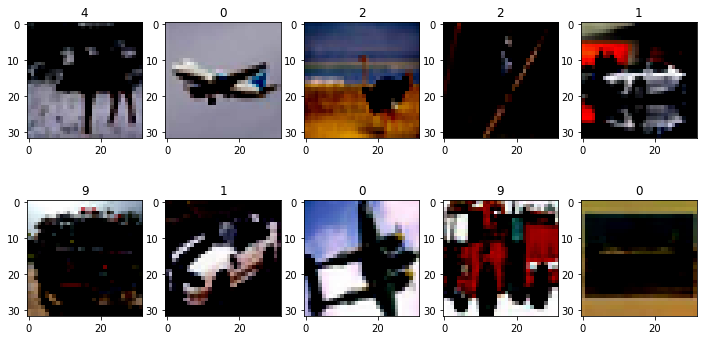

In [43]:
# 2) Checking the dataset
data_iter = iter(training_loader)
images, labels = next(data_iter)
print(images.shape)

def image_converter(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
#     image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
#     image = color.rgb2gray(image)
    return image

print(image_converter(images[3]).shape)
print(training_loader.dataset.class_to_idx)
fig = plt.figure(figsize=(12, 6))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    plt.imshow(image_converter(images[i]))
    ax.set_title(labels[i].item())

In [24]:
# 3) Building the model 
class MyCifar10(nn.Module):
    def __init__(self, input_size, H1, H2, H3, H4, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, H4)
        self.linear5 = nn.Linear(H4, output_size)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = self.linear5(x)
        return x
        
model = MyCifar10(1024, 513, 257, 129, 65, 10).to(device)
model

MyCifar10(
  (linear1): Linear(in_features=1024, out_features=513, bias=True)
  (linear2): Linear(in_features=513, out_features=257, bias=True)
  (linear3): Linear(in_features=257, out_features=129, bias=True)
  (linear4): Linear(in_features=129, out_features=65, bias=True)
  (linear5): Linear(in_features=65, out_features=10, bias=True)
)

In [25]:
# 4) Training the model 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 25

running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for inputs, labels in training_loader:
        inputs = inputs[:, 0, :, :] + inputs[:, 1, :, :] + inputs[:, 2, :, :]
        inputs = inputs.view(inputs.shape[0], -1).to(device)
        outputs = model(inputs).to(device)
        loss = criterion(outputs.to(device), labels.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds.to(device) == labels.data.to(device))
    
    else: 
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs[:, 0, :, :] + val_inputs[:, 1, :, :] + val_inputs[:, 2, :, :]
                val_inputs = val_inputs.view(val_inputs.shape[0], -1).to(device)
                val_outputs = model(val_inputs).to(device)
                val_loss = criterion(val_outputs.to(device), val_labels.to(device))
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds.to(device) == val_labels.data.to(device))
                
        epoch_loss = running_loss / len(training_loader)
        epoch_acc = float(running_corrects.item()) / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = float(val_running_corrects.item()) / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print("loss : {:.4f}, acc : {:.4f} || v_loss : {:.4f}, v_acc : {:.4f}".format(epoch_loss,
                                                                                    epoch_acc, 
                                                                                    val_epoch_loss, 
                                                                                    val_epoch_acc))

loss : 1.9774, acc : 29.4020 || v_loss : 1.8297, v_acc : 35.2300
loss : 1.7764, acc : 37.2220 || v_loss : 1.7321, v_acc : 38.9100
loss : 1.6860, acc : 40.8880 || v_loss : 1.6826, v_acc : 40.7200
loss : 1.6134, acc : 43.5340 || v_loss : 1.6379, v_acc : 42.2200
loss : 1.5517, acc : 45.8260 || v_loss : 1.6152, v_acc : 42.4300
loss : 1.4955, acc : 47.7560 || v_loss : 1.5821, v_acc : 44.4100
loss : 1.4424, acc : 49.3880 || v_loss : 1.5737, v_acc : 45.1100
loss : 1.3941, acc : 51.2640 || v_loss : 1.5641, v_acc : 45.5300
loss : 1.3473, acc : 52.8320 || v_loss : 1.5625, v_acc : 45.5000
loss : 1.3090, acc : 54.1580 || v_loss : 1.5656, v_acc : 45.8000
loss : 1.2695, acc : 55.7640 || v_loss : 1.5552, v_acc : 45.6700
loss : 1.2254, acc : 57.1320 || v_loss : 1.5864, v_acc : 45.8500
loss : 1.1907, acc : 58.3500 || v_loss : 1.5664, v_acc : 46.1500
loss : 1.1521, acc : 59.5940 || v_loss : 1.5796, v_acc : 46.6200
loss : 1.1165, acc : 61.1500 || v_loss : 1.5819, v_acc : 46.7600
loss : 1.0818, acc : 62.0

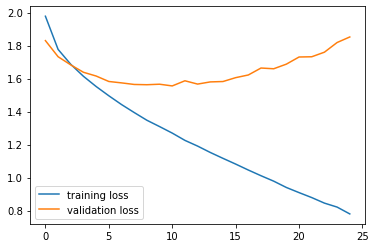

In [28]:
# 5) plotting the curves
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

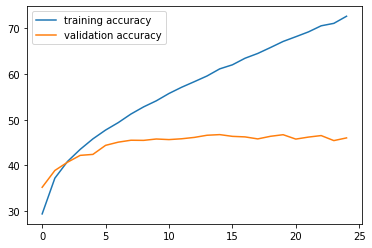

In [29]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

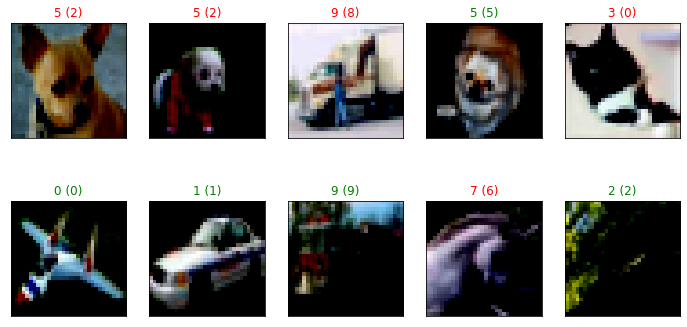

In [66]:
# 6) Testting
test_data_iter = iter(training_loader)
test_images, test_labels = next(data_iter)
test_input = test_images[:, 0, :, :] + test_images[:, 1, :, :] + test_images[:, 2, :, :]
test_input = test_input.view(test_input.shape[0], -1).to(device)
test_output = model(test_input).to(device)

_, test_preds = torch.max(test_output, 1)


fig = plt.figure(figsize=(12, 6))
for indx in range(10):
    ax = fig.add_subplot(2, 5, indx+1, xticks=[], yticks=[])
    plt.imshow(image_converter(test_images[indx]))
    ax.set_title("{} ({})".format(test_labels[indx], test_preds[indx]),
                 color=("green" if test_labels[indx] == test_preds[indx] else "red"))

In [ ]:
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))
     